# ViT CIFAR-10
load timm ViT and retrain on CIFAR 10

In [14]:
NOQUANT_TRAIN = False
modelname = "vit_small_patch16_224"

In [5]:
import argparse
import os
import shutil
import time
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import time
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

DATA_DIR = "train"
print_freq = 50

# vit imsize
imsize = 224

In [6]:
# prepare labels
train_df = pd.read_csv("trainLabels.csv")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['label_enc'] = le.fit_transform(train_df['label'])

# 5-fold
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_df["fold"] = -1
for i, (train_index, test_index) in enumerate(skf.split(train_df.id, train_df.label_enc)):
    train_df.loc[test_index, 'fold'] = i
train_df.head()

,id,label,label_enc,fold
0,1,frog,6,1
1,2,truck,9,1
2,3,truck,9,2
3,4,deer,4,1
4,5,automobile,1,2


In [7]:
class cifarDataset(Dataset):
    def __init__(self,
                 df,
                 rand=False,
                 transform=None,
                 test=False
                ):

        self.df = df.reset_index(drop=True)
        self.rand = rand
        self.transform = transform
        self.test = test

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.id
        
        images = cv2.imread(os.path.join(DATA_DIR, str(img_id)+".png"))
        
        # Load labels
        label = row.label_enc
        
        # aug
        if self.transform is not None:
            images = self.transform(image=images)['image']
              
        #images = images.astype(np.float32)
        #images /= 255
        images = images.transpose(2, 0, 1)
        
        label = label.astype(np.float32)
        #label2 = label2.astype(np.float32)
        return torch.tensor(images), torch.tensor(label),

In [8]:
import albumentations as A
import albumentations

transforms_train = albumentations.Compose([
    albumentations.ShiftScaleRotate(scale_limit=0.3, rotate_limit=180,p=0.5),
    A.Cutout(num_holes=12, max_h_size=4, max_w_size=4, fill_value=0, p=0.5),
    #albumentations.Rotate(p=0.5),
    #albumentations.Transpose(p=0.5),
    #albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),   
    albumentations.Resize(imsize, imsize, p=1.0), 
    albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),
])

transforms_val = albumentations.Compose([albumentations.Resize(imsize, imsize, p=1.0),
                                         albumentations.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225), p=1),])

/home/ken/anaconda3/envs/pytorch_p38_2/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

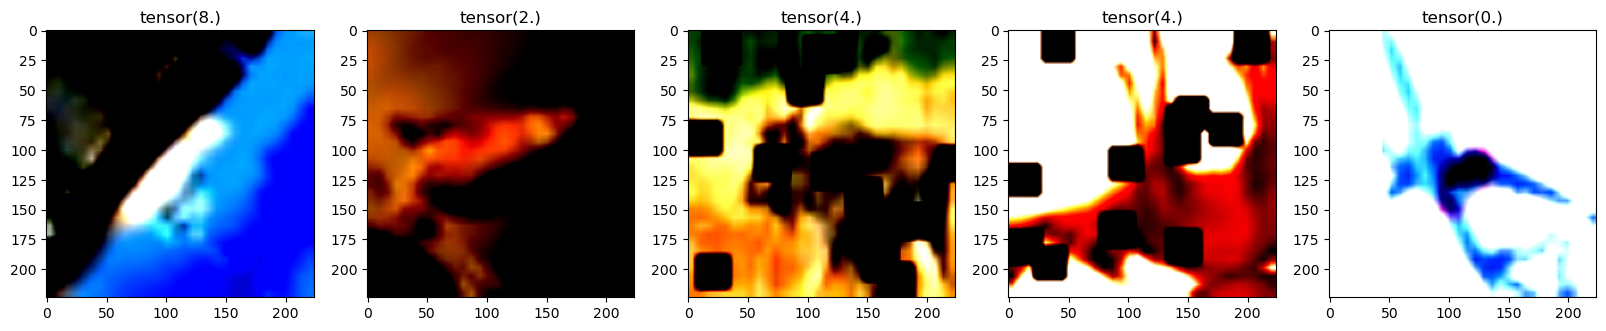

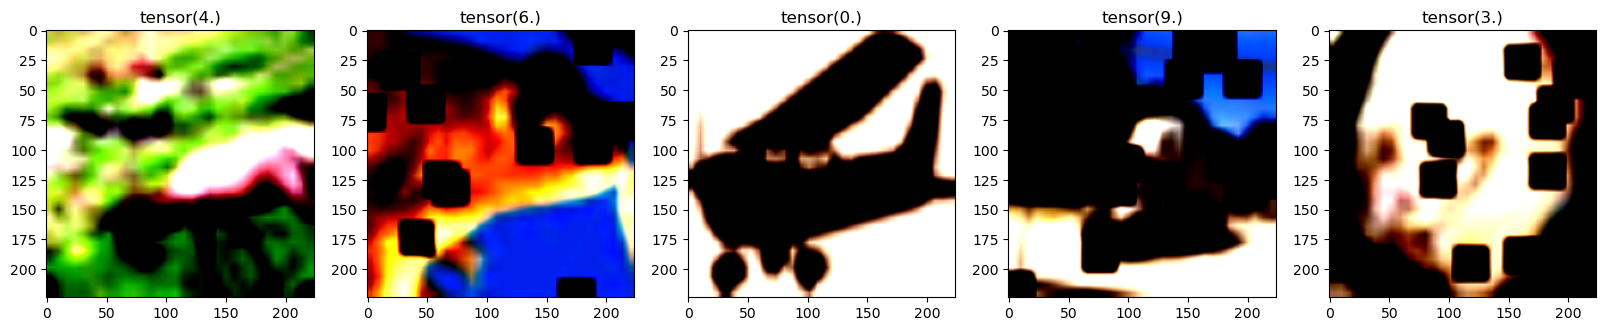

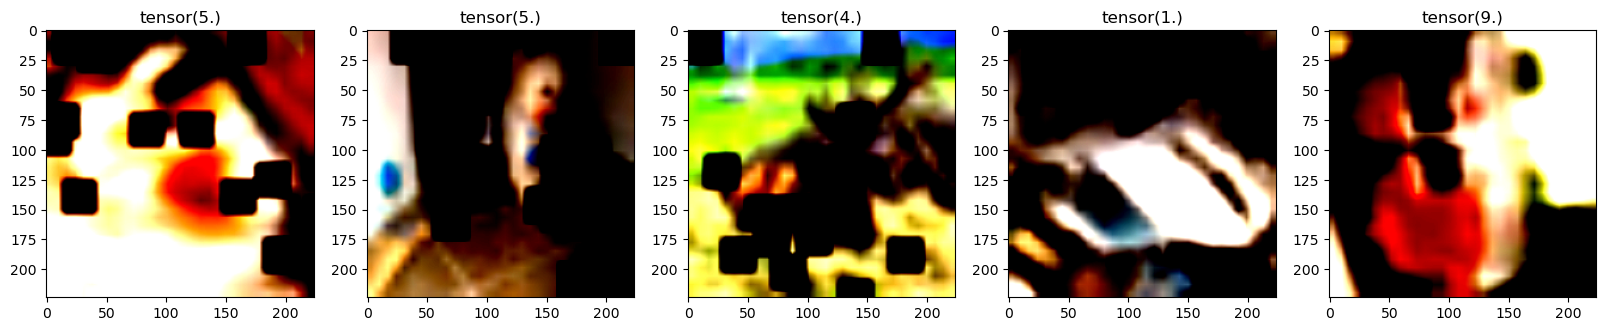

In [9]:
dataset_show = cifarDataset(train_df, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(3):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = img.flip(0) #BGR2RGB
        axarr[p].imshow(img.transpose(0,1).transpose(1,2))
        axarr[p].set_title(str(label))
plt.show()

In [10]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    lambda_alpha = 0.002
    for i, (input, target) in enumerate(tqdm(train_loader)):

        # measure data loading time
        data_time.update(time.time() - end)
        target2 = target

        target = target.long().cuda()
        target2 = target2.long().cuda()
        input_var = input.cuda()
        target_var = target

        if not mixup:
          alpha = 0
        else:
          alpha = 1
        

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # L2 regularization
        l2_alpha = 0.0
        for name, param in model.named_parameters():
            if "alpha" in name:
                l2_alpha += torch.pow(param, 2)
        loss += lambda_alpha * l2_alpha

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))
    return losses.avg

def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            target = target.long().cuda()
            input_var = input.cuda()
            target_var = target.cuda()

            # compute output
            output = model(input_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))
    for name, param in model.named_parameters():
        if "alpha" in name:
            print(name, param.item())
    return top1.avg, losses.avg

def save_checkpoint(state, filename='checkpoint.pth'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [11]:
train_dataset = cifarDataset(train_df[train_df.fold!=0], transform=transforms_train)
val_dataset = cifarDataset(train_df[train_df.fold==0], transform=transforms_val, test=True)

train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=256, shuffle=True,
        num_workers=8, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=512, shuffle=False,
    num_workers=8, pin_memory=True)

In [15]:
import timm
net = timm.create_model(modelname, pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)

# Train VIT without quantization

In [16]:
model = net.cuda()
mixup = False

import wandb
watermark = "vit_small_noquant"
wandb.init(project="pact_vit",
            name=watermark)

# define loss function (criterion) and pptimizer
criterion = nn.CrossEntropyLoss().cuda()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                            momentum=0.9,
                            weight_decay=0.0002)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                    milestones=[80, 150],)

best_prec1 = 0
os.makedirs("models", exist_ok=True)

if NOQUANT_TRAIN:
    for epoch in range(10):
        # train for one epoch
        print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
        tloss = train(train_loader, model, criterion, optimizer, epoch)
        lr_scheduler.step()

        # evaluate on validation set
        prec1, valloss = validate(val_loader, model, criterion)

        # wandb
        wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)

        print("Best prec1 : ", best_prec1)
        if is_best:
            torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

wandb: Currently logged in as: arutema47 (keio-csg). Use `wandb login --relogin` to force relogin


# Train with quantization

In [17]:
from module import ActFn

# For activation quantization
class Activation(nn.Module):
    def __init__(self, k):
        super().__init__()
        self.ActFn = ActFn.apply
        self.k = k
        self.alpha = nn.Parameter(torch.tensor(10.))
    
    def forward(self, x):
        return self.ActFn(x, self.alpha, self.k)

In [18]:
# have fun with timm models

from timm.models.layers import PatchEmbed, Mlp, DropPath, trunc_normal_, lecun_normal_
from timm.models.registry import register_model
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from timm.models.helpers import build_model_with_cfg, named_apply, adapt_input_conv
from functools import partial
from pact_utils import QuantizedLinear

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0., k=8, pact=False):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = QuantizedLinear(in_features, hidden_features, True, k, k, pact)
        self.act = act_layer()
        self.fc2 = QuantizedLinear(hidden_features, out_features, True, k, k, pact)
        self.drop = nn.Dropout(drop)
        
        # PACT
        self.k = k
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0., k=8, pact=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = QuantizedLinear(dim, dim * 3, qkv_bias, k, k, pact)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = QuantizedLinear(dim, dim, True, k, k, pact)
        self.proj_drop = nn.Dropout(proj_drop)
        
        # PACT
        #self.alpha1 = nn.Parameter(torch.tensor(2.))
        #self.alpha2 = nn.Parameter(torch.tensor(2.))
        #self.alpha3 = nn.Parameter(torch.tensor(2.))
        #self.alpha4 = nn.Parameter(torch.tensor(2.))
        #self.quant = ActFn.apply
        self.k = k

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, k=8, pact=False):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop, k=k, pact=pact)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop, k=k)

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x


class VisionTransformer(nn.Module):
    """ Vision Transformer
    A PyTorch impl of : `An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale`
        - https://arxiv.org/abs/2010.11929
    Includes distillation token & head support for `DeiT: Data-efficient Image Transformers`
        - https://arxiv.org/abs/2012.12877
    """

    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dim=768, depth=12,
                 num_heads=12, mlp_ratio=4., qkv_bias=True, representation_size=None, distilled=False,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., embed_layer=PatchEmbed, norm_layer=None,
                 act_layer=None, weight_init='', k=8, pact=False):
        """
        Args:
            img_size (int, tuple): input image size
            patch_size (int, tuple): patch size
            in_chans (int): number of input channels
            num_classes (int): number of classes for classification head
            embed_dim (int): embedding dimension
            depth (int): depth of transformer
            num_heads (int): number of attention heads
            mlp_ratio (int): ratio of mlp hidden dim to embedding dim
            qkv_bias (bool): enable bias for qkv if True
            representation_size (Optional[int]): enable and set representation layer (pre-logits) to this value if set
            distilled (bool): model includes a distillation token and head as in DeiT models
            drop_rate (float): dropout rate
            attn_drop_rate (float): attention dropout rate
            drop_path_rate (float): stochastic depth rate
            embed_layer (nn.Module): patch embedding layer
            norm_layer: (nn.Module): normalization layer
            weight_init: (str): weight init scheme
        """
        super().__init__()
        self.num_classes = num_classes
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        self.num_tokens = 2 if distilled else 1
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.patch_embed = embed_layer(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.dist_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) if distilled else None
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + self.num_tokens, embed_dim))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            Block(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, drop=drop_rate,
                attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer, act_layer=act_layer, k=k, pact=pact)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)

        # Representation layer
        if representation_size and not distilled:
            self.num_features = representation_size
            self.pre_logits = nn.Sequential(OrderedDict([
                ('fc', nn.Linear(embed_dim, representation_size)),
                ('act', nn.Tanh())
            ]))
        else:
            self.pre_logits = nn.Identity()

        # Classifier head(s)
        self.head = nn.Linear(self.num_features, num_classes) if num_classes > 0 else nn.Identity()
        self.head_dist = None
        if distilled:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

        self.init_weights(weight_init)

    def init_weights(self, mode=''):
        assert mode in ('jax', 'jax_nlhb', 'nlhb', '')
        head_bias = -math.log(self.num_classes) if 'nlhb' in mode else 0.
        trunc_normal_(self.pos_embed, std=.02)
        if self.dist_token is not None:
            trunc_normal_(self.dist_token, std=.02)
        if mode.startswith('jax'):
            # leave cls token as zeros to match jax impl
            named_apply(partial(_init_vit_weights, head_bias=head_bias, jax_impl=True), self)
        else:
            trunc_normal_(self.cls_token, std=.02)
            self.apply(_init_vit_weights)

    def _init_weights(self, m):
        # this fn left here for compat with downstream users
        _init_vit_weights(m)

    @torch.jit.ignore()
    def load_pretrained(self, checkpoint_path, prefix=''):
        _load_weights(self, checkpoint_path, prefix)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed', 'cls_token', 'dist_token'}

    def get_classifier(self):
        if self.dist_token is None:
            return self.head
        else:
            return self.head, self.head_dist

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()
        if self.num_tokens == 2:
            self.head_dist = nn.Linear(self.embed_dim, self.num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)  # stole cls_tokens impl from Phil Wang, thanks
        if self.dist_token is None:
            x = torch.cat((cls_token, x), dim=1)
        else:
            x = torch.cat((cls_token, self.dist_token.expand(x.shape[0], -1, -1), x), dim=1)
        x = self.pos_drop(x + self.pos_embed)
        x = self.blocks(x)
        x = self.norm(x)
        if self.dist_token is None:
            return self.pre_logits(x[:, 0])
        else:
            return x[:, 0], x[:, 1]

    def forward(self, x):
        x = self.forward_features(x)
        if self.head_dist is not None:
            x, x_dist = self.head(x[0]), self.head_dist(x[1])  # x must be a tuple
            if self.training and not torch.jit.is_scripting():
                # during inference, return the average of both classifier predictions
                return x, x_dist
            else:
                return (x + x_dist) / 2
        else:
            x = self.head(x)
        return x


def _init_vit_weights(module: nn.Module, name: str = '', head_bias: float = 0., jax_impl: bool = False):
    """ ViT weight initialization
    * When called without n, head_bias, jax_impl args it will behave exactly the same
      as my original init for compatibility with prev hparam / downstream use cases (ie DeiT).
    * When called w/ valid n (module name) and jax_impl=True, will (hopefully) match JAX impl
    """
    if isinstance(module, nn.Linear):
        if name.startswith('head'):
            nn.init.zeros_(module.weight)
            nn.init.constant_(module.bias, head_bias)
        elif name.startswith('pre_logits'):
            lecun_normal_(module.weight)
            nn.init.zeros_(module.bias)
        else:
            if jax_impl:
                nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    if 'mlp' in name:
                        nn.init.normal_(module.bias, std=1e-6)
                    else:
                        nn.init.zeros_(module.bias)
            else:
                trunc_normal_(module.weight, std=.02)
                if module.bias is not None:
                    nn.init.zeros_(module.bias)
    elif jax_impl and isinstance(module, nn.Conv2d):
        # NOTE conv was left to pytorch default in my original init
        lecun_normal_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, (nn.LayerNorm, nn.GroupNorm, nn.BatchNorm2d)):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)


@torch.no_grad()
def _load_weights(model: VisionTransformer, checkpoint_path: str, prefix: str = ''):
    """ Load weights from .npz checkpoints for official Google Brain Flax implementation
    """
    import numpy as np

    def _n2p(w, t=True):
        if w.ndim == 4 and w.shape[0] == w.shape[1] == w.shape[2] == 1:
            w = w.flatten()
        if t:
            if w.ndim == 4:
                w = w.transpose([3, 2, 0, 1])
            elif w.ndim == 3:
                w = w.transpose([2, 0, 1])
            elif w.ndim == 2:
                w = w.transpose([1, 0])
        return torch.from_numpy(w)

    w = np.load(checkpoint_path)
    if not prefix and 'opt/target/embedding/kernel' in w:
        prefix = 'opt/target/'

    if hasattr(model.patch_embed, 'backbone'):
        # hybrid
        backbone = model.patch_embed.backbone
        stem_only = not hasattr(backbone, 'stem')
        stem = backbone if stem_only else backbone.stem
        stem.conv.weight.copy_(adapt_input_conv(stem.conv.weight.shape[1], _n2p(w[f'{prefix}conv_root/kernel'])))
        stem.norm.weight.copy_(_n2p(w[f'{prefix}gn_root/scale']))
        stem.norm.bias.copy_(_n2p(w[f'{prefix}gn_root/bias']))
        if not stem_only:
            for i, stage in enumerate(backbone.stages):
                for j, block in enumerate(stage.blocks):
                    bp = f'{prefix}block{i + 1}/unit{j + 1}/'
                    for r in range(3):
                        getattr(block, f'conv{r + 1}').weight.copy_(_n2p(w[f'{bp}conv{r + 1}/kernel']))
                        getattr(block, f'norm{r + 1}').weight.copy_(_n2p(w[f'{bp}gn{r + 1}/scale']))
                        getattr(block, f'norm{r + 1}').bias.copy_(_n2p(w[f'{bp}gn{r + 1}/bias']))
                    if block.downsample is not None:
                        block.downsample.conv.weight.copy_(_n2p(w[f'{bp}conv_proj/kernel']))
                        block.downsample.norm.weight.copy_(_n2p(w[f'{bp}gn_proj/scale']))
                        block.downsample.norm.bias.copy_(_n2p(w[f'{bp}gn_proj/bias']))
        embed_conv_w = _n2p(w[f'{prefix}embedding/kernel'])
    else:
        embed_conv_w = adapt_input_conv(
            model.patch_embed.proj.weight.shape[1], _n2p(w[f'{prefix}embedding/kernel']))
    model.patch_embed.proj.weight.copy_(embed_conv_w)
    model.patch_embed.proj.bias.copy_(_n2p(w[f'{prefix}embedding/bias']))
    model.cls_token.copy_(_n2p(w[f'{prefix}cls'], t=False))
    pos_embed_w = _n2p(w[f'{prefix}Transformer/posembed_input/pos_embedding'], t=False)
    if pos_embed_w.shape != model.pos_embed.shape:
        pos_embed_w = resize_pos_embed(  # resize pos embedding when different size from pretrained weights
            pos_embed_w, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
    model.pos_embed.copy_(pos_embed_w)
    model.norm.weight.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/scale']))
    model.norm.bias.copy_(_n2p(w[f'{prefix}Transformer/encoder_norm/bias']))
    if isinstance(model.head, nn.Linear) and model.head.bias.shape[0] == w[f'{prefix}head/bias'].shape[-1]:
        model.head.weight.copy_(_n2p(w[f'{prefix}head/kernel']))
        model.head.bias.copy_(_n2p(w[f'{prefix}head/bias']))
    if isinstance(getattr(model.pre_logits, 'fc', None), nn.Linear) and f'{prefix}pre_logits/bias' in w:
        model.pre_logits.fc.weight.copy_(_n2p(w[f'{prefix}pre_logits/kernel']))
        model.pre_logits.fc.bias.copy_(_n2p(w[f'{prefix}pre_logits/bias']))
    for i, block in enumerate(model.blocks.children()):
        block_prefix = f'{prefix}Transformer/encoderblock_{i}/'
        mha_prefix = block_prefix + 'MultiHeadDotProductAttention_1/'
        block.norm1.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/scale']))
        block.norm1.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_0/bias']))
        block.attn.qkv.weight.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/kernel'], t=False).flatten(1).T for n in ('query', 'key', 'value')]))
        block.attn.qkv.bias.copy_(torch.cat([
            _n2p(w[f'{mha_prefix}{n}/bias'], t=False).reshape(-1) for n in ('query', 'key', 'value')]))
        block.attn.proj.weight.copy_(_n2p(w[f'{mha_prefix}out/kernel']).flatten(1))
        block.attn.proj.bias.copy_(_n2p(w[f'{mha_prefix}out/bias']))
        for r in range(2):
            getattr(block.mlp, f'fc{r + 1}').weight.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/kernel']))
            getattr(block.mlp, f'fc{r + 1}').bias.copy_(_n2p(w[f'{block_prefix}MlpBlock_3/Dense_{r}/bias']))
        block.norm2.weight.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/scale']))
        block.norm2.bias.copy_(_n2p(w[f'{block_prefix}LayerNorm_2/bias']))


def resize_pos_embed(posemb, posemb_new, num_tokens=1, gs_new=()):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    _logger.info('Resized position embedding: %s to %s', posemb.shape, posemb_new.shape)
    ntok_new = posemb_new.shape[1]
    if num_tokens:
        posemb_tok, posemb_grid = posemb[:, :num_tokens], posemb[0, num_tokens:]
        ntok_new -= num_tokens
    else:
        posemb_tok, posemb_grid = posemb[:, :0], posemb[0]
    gs_old = int(math.sqrt(len(posemb_grid)))
    if not len(gs_new):  # backwards compatibility
        gs_new = [int(math.sqrt(ntok_new))] * 2
    assert len(gs_new) >= 2
    _logger.info('Position embedding grid-size from %s to %s', [gs_old, gs_old], gs_new)
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=gs_new, mode='bicubic', align_corners=False)
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, gs_new[0] * gs_new[1], -1)
    posemb = torch.cat([posemb_tok, posemb_grid], dim=1)
    return posemb


def checkpoint_filter_fn(state_dict, model):
    """ convert patch embedding weight from manual patchify + linear proj to conv"""
    out_dict = {}
    if 'model' in state_dict:
        # For deit models
        state_dict = state_dict['model']
    for k, v in state_dict.items():
        if 'patch_embed.proj.weight' in k and len(v.shape) < 4:
            # For old models that I trained prior to conv based patchification
            O, I, H, W = model.patch_embed.proj.weight.shape
            v = v.reshape(O, -1, H, W)
        elif k == 'pos_embed' and v.shape != model.pos_embed.shape:
            # To resize pos embedding when using model at different size from pretrained weights
            v = resize_pos_embed(
                v, model.pos_embed, getattr(model, 'num_tokens', 1), model.patch_embed.grid_size)
        out_dict[k] = v
    return out_dict


def _create_vision_transformer(variant, pretrained=False, default_cfg=None, **kwargs):
    default_cfg = default_cfg or default_cfgs[variant]
    if kwargs.get('features_only', None):
        raise RuntimeError('features_only not implemented for Vision Transformer models.')

    # NOTE this extra code to support handling of repr size for in21k pretrained models
    default_num_classes = default_cfg['num_classes']
    num_classes = kwargs.get('num_classes', default_num_classes)
    repr_size = kwargs.pop('representation_size', None)
    if repr_size is not None and num_classes != default_num_classes:
        # Remove representation layer if fine-tuning. This may not always be the desired action,
        # but I feel better than doing nothing by default for fine-tuning. Perhaps a better interface?
        _logger.warning("Removing representation layer for fine-tuning.")
        repr_size = None

    model = build_model_with_cfg(
        VisionTransformer, variant, pretrained,
        default_cfg=default_cfg,
        representation_size=repr_size,
        pretrained_filter_fn=checkpoint_filter_fn,
        pretrained_custom_load='npz' in default_cfg['url'],
        **kwargs)
    return model

def _cfg(url='', **kwargs):
    return {
        'url': url,
        'num_classes': 1000, 'input_size': (3, 224, 224), 'pool_size': None,
        'crop_pct': .9, 'interpolation': 'bicubic', 'fixed_input_size': True,
        'mean': IMAGENET_INCEPTION_MEAN, 'std': IMAGENET_INCEPTION_STD,
        'first_conv': 'patch_embed.proj', 'classifier': 'head',
        **kwargs
    }

default_cfgs = {
    # patch models (weights from official Google JAX impl)
    'vit_tiny_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    'vit_small_patch16_224': _cfg(
        url='https://storage.googleapis.com/vit_models/augreg/'
            'S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz'),
    }

@register_model
def vit_tiny_patch16_224(pretrained=False, k=8, pact=False, **kwargs):
    """ ViT-Tiny (Vit-Ti/16)
    """
    model_kwargs = dict(patch_size=16, embed_dim=192, depth=12, num_heads=3, k=k, pact=pact, **kwargs)
    model = _create_vision_transformer('vit_tiny_patch16_224', pretrained=pretrained, **model_kwargs)
    return model

@register_model
def vit_small_patch16_224(pretrained=False, k=8, **kwargs):
    """ ViT-Small (ViT-S/16)
    NOTE I've replaced my previous 'small' model definition and weights with the small variant from the DeiT paper
    """
    model_kwargs = dict(patch_size=16, embed_dim=384, depth=12, num_heads=6, k=k, **kwargs)
    model = _create_vision_transformer('vit_small_patch16_224', pretrained=pretrained, **model_kwargs)
    return model


In [ ]:
from timm.scheduler import CosineLRScheduler

for PACT in [False,]:
    for k in range(4,9):
        net = vit_tiny_patch16_224(True, k=k, pact=PACT)
        net.head = nn.Linear(net.head.in_features, 10)
        checkpoint = torch.load("models/vit_tiny_noquant.pth")
        net.load_state_dict(checkpoint, strict=False)

        model = net.cuda()
        mixup = False

        # Track experiment with wandb
        import wandb
        watermark = "vit_small_k{}".format(k)
        if PACT == False:
            watermark+="_nopact"
        else:
            watermark+="_pact"
        
        # mess with wandb
        wandb.init(project="pact_vit_20220617", name=watermark)

        # define loss function (criterion) and pptimizer
        criterion = nn.CrossEntropyLoss().cuda()

        # optimizer for pact
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,
                                    momentum=0.9,
                                    weight_decay=0.0002)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        scheduler = CosineLRScheduler(optimizer, t_initial=10, lr_min=1e-6, 
                              warmup_t=3, warmup_lr_init=1e-6, warmup_prefix=True)

        best_prec1 = 0
        os.makedirs("models", exist_ok=True)

        for epoch in range(10):
            scheduler.step(epoch)
            # train for one epoch
            print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
            tloss = train(train_loader, model, criterion, optimizer, epoch)         

            # evaluate on validation set
            prec1, valloss = validate(val_loader, model, criterion)

            # wandb
            wandb.log({'epoch': epoch, "prec":prec1, "train_loss": tloss, 'val_loss': valloss, "lr": optimizer.param_groups[0]["lr"],})

            # remember best prec@1 and save checkpoint
            is_best = prec1 > best_prec1
            best_prec1 = max(prec1, best_prec1)

            print("Best prec1 : ", best_prec1)
            if is_best:
                torch.save(model.state_dict(), os.path.join(f'models/{watermark}.pth'))

current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 3.693 (3.693)	Data 1.482 (1.482)	Loss 2.9415 (2.9415)	Prec@1 13.281 (13.281)
Epoch: [0][50/157]	Time 0.843 (0.896)	Data 0.001 (0.030)	Loss 2.2103 (2.4404)	Prec@1 15.625 (16.238)
Epoch: [0][100/157]	Time 0.846 (0.870)	Data 0.001 (0.016)	Loss 2.0984 (2.2991)	Prec@1 23.047 (18.723)
Epoch: [0][150/157]	Time 0.846 (0.862)	Data 0.001 (0.011)	Loss 2.0294 (2.2231)	Prec@1 32.422 (20.698)
Test: [0/20]	Time 3.176 (3.176)	Loss 1.9290 (1.9290)	Prec@1 31.641 (31.641)
 * Prec@1 29.750
Best prec1 :  29.749999963378905
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.951 (1.951)	Data 1.104 (1.104)	Loss 2.0621 (2.0621)	Prec@1 26.562 (26.562)
Epoch: [1][50/157]	Time 0.846 (0.868)	Data 0.001 (0.023)	Loss 1.8023 (1.9215)	Prec@1 33.594 (29.887)
Epoch: [1][100/157]	Time 0.847 (0.858)	Data 0.001 (0.012)	Loss 1.7204 (1.8445)	Prec@1 37.500 (32.724)
Epoch: [1][150/157]	Time 0.847 (0.854)	Data 0.001 (0.008)	Loss 1.5470 (1.7849)	Prec@1 45.312 (35.099)
Test: [0/20]	Time 2.820 (2.820)	Loss 1.4551 (1.4551)	Prec@1 49.609 (49.609)
 * Prec@1 49.140
Best prec1 :  49.13999997558594
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.202 (2.202)	Data 1.356 (1.356)	Loss 1.5998 (1.5998)	Prec@1 41.797 (41.797)
Epoch: [2][50/157]	Time 0.846 (0.873)	Data 0.001 (0.028)	Loss 1.4090 (1.4939)	Prec@1 51.562 (46.071)
Epoch: [2][100/157]	Time 0.847 (0.860)	Data 0.001 (0.014)	Loss 1.2469 (1.4142)	Prec@1 55.859 (49.292)
Epoch: [2][150/157]	Time 0.846 (0.856)	Data 0.001 (0.010)	Loss 1.0890 (1.3418)	Prec@1 60.156 (52.059)
Test: [0/20]	Time 6.105 (6.105)	Loss 0.8819 (0.8819)	Prec@1 67.773 (67.773)
 * Prec@1 68.720
Best prec1 :  68.72
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.001 (2.001)	Data 1.150 (1.150)	Loss 1.0727 (1.0727)	Prec@1 62.109 (62.109)
Epoch: [3][50/157]	Time 0.846 (0.869)	Data 0.001 (0.024)	Loss 1.0445 (1.0745)	Prec@1 58.203 (61.420)
Epoch: [3][100/157]	Time 0.847 (0.858)	Data 0.001 (0.012)	Loss 0.8711 (1.0280)	Prec@1 67.188 (62.991)
Epoch: [3][150/157]	Time 0.847 (0.854)	Data 0.001 (0.009)	Loss 0.8418 (0.9936)	Prec@1 66.406 (64.202)
Test: [0/20]	Time 2.356 (2.356)	Loss 0.5907 (0.5907)	Prec@1 79.492 (79.492)
 * Prec@1 79.950
Best prec1 :  79.94999986572266
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.979 (1.979)	Data 1.132 (1.132)	Loss 0.8971 (0.8971)	Prec@1 65.625 (65.625)
Epoch: [4][50/157]	Time 0.847 (0.869)	Data 0.001 (0.023)	Loss 0.7754 (0.8599)	Prec@1 73.438 (69.493)
Epoch: [4][100/157]	Time 0.847 (0.858)	Data 0.001 (0.012)	Loss 0.7073 (0.8359)	Prec@1 76.562 (70.432)
Epoch: [4][150/157]	Time 0.846 (0.854)	Data 0.001 (0.008)	Loss 0.8977 (0.8144)	Prec@1 68.359 (71.228)
Test: [0/20]	Time 2.549 (2.549)	Loss 0.4705 (0.4705)	Prec@1 83.789 (83.789)
 * Prec@1 83.700
Best prec1 :  83.69999993896485
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.821 (1.821)	Data 0.973 (0.973)	Loss 0.8206 (0.8206)	Prec@1 71.484 (71.484)
Epoch: [5][50/157]	Time 0.846 (0.865)	Data 0.001 (0.020)	Loss 0.6903 (0.7511)	Prec@1 77.734 (73.369)
Epoch: [5][100/157]	Time 0.847 (0.856)	Data 0.001 (0.011)	Loss 0.6851 (0.7351)	Prec@1 76.562 (74.018)
Epoch: [5][150/157]	Time 0.847 (0.853)	Data 0.001 (0.007)	Loss 0.6661 (0.7231)	Prec@1 76.172 (74.454)
Test: [0/20]	Time 1.998 (1.998)	Loss 0.3764 (0.3764)	Prec@1 87.695 (87.695)
 * Prec@1 86.240
Best prec1 :  86.23999991455078
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.699 (1.699)	Data 0.840 (0.840)	Loss 0.7910 (0.7910)	Prec@1 73.438 (73.438)
Epoch: [6][50/157]	Time 0.847 (0.863)	Data 0.001 (0.018)	Loss 0.6130 (0.6779)	Prec@1 78.906 (76.233)
Epoch: [6][100/157]	Time 0.847 (0.855)	Data 0.001 (0.009)	Loss 0.5966 (0.6739)	Prec@1 78.125 (76.392)
Epoch: [6][150/157]	Time 0.847 (0.852)	Data 0.001 (0.007)	Loss 0.6365 (0.6637)	Prec@1 76.953 (76.832)
Test: [0/20]	Time 2.168 (2.168)	Loss 0.3503 (0.3503)	Prec@1 89.062 (89.062)
 * Prec@1 87.780
Best prec1 :  87.77999987792968
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 2.107 (2.107)	Data 1.261 (1.261)	Loss 0.6977 (0.6977)	Prec@1 73.828 (73.828)
Epoch: [7][50/157]	Time 0.847 (0.871)	Data 0.001 (0.026)	Loss 0.6355 (0.6283)	Prec@1 78.516 (77.619)
Epoch: [7][100/157]	Time 0.847 (0.859)	Data 0.001 (0.013)	Loss 0.5755 (0.6199)	Prec@1 79.688 (77.966)
Epoch: [7][150/157]	Time 0.847 (0.855)	Data 0.001 (0.009)	Loss 0.5053 (0.6200)	Prec@1 80.469 (77.921)
Test: [0/20]	Time 1.865 (1.865)	Loss 0.3173 (0.3173)	Prec@1 90.625 (90.625)
 * Prec@1 88.520
Best prec1 :  88.51999998779297
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.761 (1.761)	Data 0.901 (0.901)	Loss 0.5754 (0.5754)	Prec@1 78.906 (78.906)
Epoch: [8][50/157]	Time 0.847 (0.864)	Data 0.001 (0.019)	Loss 0.6298 (0.5908)	Prec@1 77.344 (79.136)
Epoch: [8][100/157]	Time 0.847 (0.856)	Data 0.001 (0.010)	Loss 0.5989 (0.5950)	Prec@1 79.688 (78.972)
Epoch: [8][150/157]	Time 0.847 (0.853)	Data 0.001 (0.007)	Loss 0.4777 (0.5941)	Prec@1 82.812 (78.948)
Test: [0/20]	Time 2.071 (2.071)	Loss 0.3147 (0.3147)	Prec@1 90.039 (90.039)
 * Prec@1 88.920
Best prec1 :  88.91999990234375
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.717 (1.717)	Data 0.858 (0.858)	Loss 0.6237 (0.6237)	Prec@1 77.734 (77.734)
Epoch: [9][50/157]	Time 0.847 (0.863)	Data 0.001 (0.018)	Loss 0.4877 (0.5944)	Prec@1 81.250 (79.213)
Epoch: [9][100/157]	Time 0.846 (0.855)	Data 0.001 (0.010)	Loss 0.6775 (0.5825)	Prec@1 75.781 (79.784)
Epoch: [9][150/157]	Time 0.847 (0.852)	Data 0.001 (0.007)	Loss 0.6538 (0.5799)	Prec@1 74.609 (79.690)
Test: [0/20]	Time 2.357 (2.357)	Loss 0.2896 (0.2896)	Prec@1 89.648 (89.648)
 * Prec@1 89.030
Best prec1 :  89.02999990234375


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▃▆▇▇█████
train_loss,█▆▄▃▂▂▁▁▁▁
val_loss,█▆▃▂▂▁▁▁▁▁
epoch,9
lr,0.0
prec,89.03
train_loss,0.58177
val_loss,0.31369


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.712 (1.712)	Data 0.865 (0.865)	Loss 1.9576 (1.9576)	Prec@1 35.938 (35.938)
Epoch: [0][50/157]	Time 0.846 (0.862)	Data 0.001 (0.018)	Loss 1.2961 (1.5813)	Prec@1 50.391 (44.707)
Epoch: [0][100/157]	Time 0.847 (0.855)	Data 0.001 (0.010)	Loss 1.0309 (1.3463)	Prec@1 66.406 (53.133)
Epoch: [0][150/157]	Time 0.847 (0.852)	Data 0.001 (0.007)	Loss 0.7171 (1.1991)	Prec@1 76.562 (58.309)
Test: [0/20]	Time 2.532 (2.532)	Loss 0.3970 (0.3970)	Prec@1 87.305 (87.305)
 * Prec@1 84.510
Best prec1 :  84.50999995117188
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.037 (2.037)	Data 1.183 (1.183)	Loss 0.7543 (0.7543)	Prec@1 75.391 (75.391)
Epoch: [1][50/157]	Time 0.847 (0.871)	Data 0.001 (0.024)	Loss 0.6857 (0.6808)	Prec@1 75.781 (76.195)
Epoch: [1][100/157]	Time 0.848 (0.859)	Data 0.001 (0.013)	Loss 0.5808 (0.6317)	Prec@1 82.422 (77.692)
Epoch: [1][150/157]	Time 0.848 (0.855)	Data 0.001 (0.009)	Loss 0.4769 (0.5992)	Prec@1 83.203 (78.834)
Test: [0/20]	Time 2.306 (2.306)	Loss 0.2153 (0.2153)	Prec@1 92.773 (92.773)
 * Prec@1 92.010
Best prec1 :  92.01000002441407
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.820 (1.820)	Data 0.970 (0.970)	Loss 0.4304 (0.4304)	Prec@1 84.766 (84.766)
Epoch: [2][50/157]	Time 0.847 (0.866)	Data 0.001 (0.020)	Loss 0.4600 (0.4905)	Prec@1 85.938 (82.912)
Epoch: [2][100/157]	Time 0.848 (0.857)	Data 0.001 (0.011)	Loss 0.3860 (0.4706)	Prec@1 89.844 (83.563)
Epoch: [2][150/157]	Time 0.847 (0.854)	Data 0.001 (0.007)	Loss 0.3767 (0.4595)	Prec@1 84.375 (83.741)
Test: [0/20]	Time 2.273 (2.273)	Loss 0.1747 (0.1747)	Prec@1 94.141 (94.141)
 * Prec@1 93.760
Best prec1 :  93.7600000366211
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.771 (1.771)	Data 0.918 (0.918)	Loss 0.4352 (0.4352)	Prec@1 85.156 (85.156)
Epoch: [3][50/157]	Time 0.848 (0.865)	Data 0.001 (0.019)	Loss 0.4651 (0.4126)	Prec@1 82.812 (85.470)
Epoch: [3][100/157]	Time 0.848 (0.857)	Data 0.001 (0.010)	Loss 0.3816 (0.4030)	Prec@1 88.672 (85.837)
Epoch: [3][150/157]	Time 0.847 (0.854)	Data 0.001 (0.007)	Loss 0.6393 (0.4025)	Prec@1 77.734 (85.831)
Test: [0/20]	Time 2.554 (2.554)	Loss 0.1238 (0.1238)	Prec@1 96.289 (96.289)
 * Prec@1 94.850
Best prec1 :  94.84999993896484
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 2.015 (2.015)	Data 1.166 (1.166)	Loss 0.4708 (0.4708)	Prec@1 84.375 (84.375)
Epoch: [4][50/157]	Time 0.847 (0.870)	Data 0.001 (0.024)	Loss 0.3750 (0.3538)	Prec@1 86.328 (87.462)
Epoch: [4][100/157]	Time 0.848 (0.859)	Data 0.001 (0.013)	Loss 0.2955 (0.3562)	Prec@1 90.234 (87.380)
Epoch: [4][150/157]	Time 0.847 (0.855)	Data 0.001 (0.009)	Loss 0.3601 (0.3537)	Prec@1 87.891 (87.536)
Test: [0/20]	Time 2.014 (2.014)	Loss 0.1250 (0.1250)	Prec@1 95.703 (95.703)
 * Prec@1 95.330
Best prec1 :  95.32999995117187
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.655 (1.655)	Data 0.802 (0.802)	Loss 0.2768 (0.2768)	Prec@1 91.016 (91.016)
Epoch: [5][50/157]	Time 0.847 (0.863)	Data 0.001 (0.017)	Loss 0.2651 (0.3365)	Prec@1 91.016 (88.526)
Epoch: [5][100/157]	Time 0.848 (0.856)	Data 0.001 (0.009)	Loss 0.4444 (0.3389)	Prec@1 84.375 (88.316)
Epoch: [5][150/157]	Time 0.847 (0.853)	Data 0.001 (0.006)	Loss 0.3128 (0.3369)	Prec@1 90.234 (88.333)
Test: [0/20]	Time 2.303 (2.303)	Loss 0.1077 (0.1077)	Prec@1 96.289 (96.289)
 * Prec@1 95.580
Best prec1 :  95.57999995117187
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.874 (1.874)	Data 1.025 (1.025)	Loss 0.2638 (0.2638)	Prec@1 89.844 (89.844)
Epoch: [6][50/157]	Time 0.848 (0.868)	Data 0.001 (0.021)	Loss 0.3051 (0.3166)	Prec@1 88.281 (89.047)
Epoch: [6][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2758 (0.3142)	Prec@1 91.016 (89.074)
Epoch: [6][150/157]	Time 0.848 (0.854)	Data 0.001 (0.008)	Loss 0.4440 (0.3149)	Prec@1 84.766 (89.065)
Test: [0/20]	Time 2.673 (2.673)	Loss 0.0878 (0.0878)	Prec@1 96.875 (96.875)
 * Prec@1 95.570
Best prec1 :  95.57999995117187
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.926 (1.926)	Data 1.077 (1.077)	Loss 0.2873 (0.2873)	Prec@1 89.453 (89.453)
Epoch: [7][50/157]	Time 0.847 (0.868)	Data 0.001 (0.022)	Loss 0.3209 (0.3113)	Prec@1 89.062 (88.664)
Epoch: [7][100/157]	Time 0.847 (0.858)	Data 0.001 (0.012)	Loss 0.2942 (0.3083)	Prec@1 89.844 (88.974)
Epoch: [7][150/157]	Time 0.847 (0.855)	Data 0.001 (0.008)	Loss 0.2774 (0.3082)	Prec@1 87.109 (88.993)
Test: [0/20]	Time 2.084 (2.084)	Loss 0.0923 (0.0923)	Prec@1 96.289 (96.289)
 * Prec@1 95.710
Best prec1 :  95.71
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.939 (1.939)	Data 1.089 (1.089)	Loss 0.2913 (0.2913)	Prec@1 90.234 (90.234)
Epoch: [8][50/157]	Time 0.847 (0.869)	Data 0.001 (0.022)	Loss 0.2486 (0.2977)	Prec@1 93.359 (89.913)
Epoch: [8][100/157]	Time 0.848 (0.858)	Data 0.001 (0.012)	Loss 0.3723 (0.2980)	Prec@1 86.719 (89.592)
Epoch: [8][150/157]	Time 0.847 (0.855)	Data 0.001 (0.008)	Loss 0.2651 (0.2991)	Prec@1 91.406 (89.683)
Test: [0/20]	Time 2.235 (2.235)	Loss 0.0951 (0.0951)	Prec@1 97.070 (97.070)
 * Prec@1 95.950
Best prec1 :  95.94999990234375
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.620 (1.620)	Data 0.770 (0.770)	Loss 0.2221 (0.2221)	Prec@1 92.188 (92.188)
Epoch: [9][50/157]	Time 0.848 (0.863)	Data 0.001 (0.016)	Loss 0.2184 (0.2804)	Prec@1 92.578 (90.104)
Epoch: [9][100/157]	Time 0.848 (0.855)	Data 0.001 (0.009)	Loss 0.2234 (0.2800)	Prec@1 91.797 (90.203)
Epoch: [9][150/157]	Time 0.847 (0.853)	Data 0.001 (0.006)	Loss 0.2624 (0.2834)	Prec@1 90.625 (90.058)
Test: [0/20]	Time 2.513 (2.513)	Loss 0.0958 (0.0958)	Prec@1 96.680 (96.680)
 * Prec@1 95.860
Best prec1 :  95.94999990234375


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▆▇▇██████
train_loss,█▃▂▂▂▁▁▁▁▁
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,9
lr,0.0
prec,95.86
train_loss,0.28491
val_loss,0.11344


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.987 (1.987)	Data 1.140 (1.140)	Loss 0.6817 (0.6817)	Prec@1 75.000 (75.000)
Epoch: [0][50/157]	Time 0.847 (0.868)	Data 0.001 (0.023)	Loss 0.3856 (0.4565)	Prec@1 85.547 (84.161)
Epoch: [0][100/157]	Time 0.849 (0.858)	Data 0.001 (0.012)	Loss 0.3101 (0.4145)	Prec@1 89.062 (85.671)
Epoch: [0][150/157]	Time 0.849 (0.855)	Data 0.001 (0.009)	Loss 0.3197 (0.3916)	Prec@1 87.891 (86.483)
Test: [0/20]	Time 1.881 (1.881)	Loss 0.1012 (0.1012)	Prec@1 96.875 (96.875)
 * Prec@1 95.760
Best prec1 :  95.75999986572266
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.617 (1.617)	Data 0.761 (0.761)	Loss 0.3396 (0.3396)	Prec@1 89.453 (89.453)
Epoch: [1][50/157]	Time 0.849 (0.864)	Data 0.001 (0.016)	Loss 0.3269 (0.3234)	Prec@1 87.891 (88.687)
Epoch: [1][100/157]	Time 0.849 (0.856)	Data 0.001 (0.009)	Loss 0.2646 (0.3081)	Prec@1 91.016 (89.248)
Epoch: [1][150/157]	Time 0.849 (0.854)	Data 0.001 (0.006)	Loss 0.2351 (0.2966)	Prec@1 91.797 (89.557)
Test: [0/20]	Time 2.477 (2.477)	Loss 0.0610 (0.0610)	Prec@1 98.242 (98.242)
 * Prec@1 96.560
Best prec1 :  96.55999997558594
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.823 (1.823)	Data 0.973 (0.973)	Loss 0.2025 (0.2025)	Prec@1 92.188 (92.188)
Epoch: [2][50/157]	Time 0.848 (0.867)	Data 0.001 (0.020)	Loss 0.3041 (0.2825)	Prec@1 89.453 (90.058)
Epoch: [2][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2829 (0.2734)	Prec@1 89.844 (90.354)
Epoch: [2][150/157]	Time 0.849 (0.855)	Data 0.001 (0.007)	Loss 0.2394 (0.2648)	Prec@1 91.406 (90.646)
Test: [0/20]	Time 2.518 (2.518)	Loss 0.0480 (0.0480)	Prec@1 98.633 (98.633)
 * Prec@1 97.120
Best prec1 :  97.11999992675781
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.869 (1.869)	Data 1.018 (1.018)	Loss 0.2418 (0.2418)	Prec@1 92.188 (92.188)
Epoch: [3][50/157]	Time 0.848 (0.868)	Data 0.001 (0.021)	Loss 0.1481 (0.2488)	Prec@1 96.484 (91.360)
Epoch: [3][100/157]	Time 0.849 (0.858)	Data 0.001 (0.011)	Loss 0.2789 (0.2475)	Prec@1 90.234 (91.298)
Epoch: [3][150/157]	Time 0.849 (0.855)	Data 0.001 (0.008)	Loss 0.2259 (0.2452)	Prec@1 92.578 (91.383)
Test: [0/20]	Time 2.061 (2.061)	Loss 0.0604 (0.0604)	Prec@1 98.438 (98.438)
 * Prec@1 97.220
Best prec1 :  97.21999992675781
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.864 (1.864)	Data 1.014 (1.014)	Loss 0.2430 (0.2430)	Prec@1 92.969 (92.969)
Epoch: [4][50/157]	Time 0.848 (0.868)	Data 0.001 (0.021)	Loss 0.2048 (0.2289)	Prec@1 92.188 (91.942)
Epoch: [4][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2824 (0.2345)	Prec@1 89.453 (91.808)
Epoch: [4][150/157]	Time 0.849 (0.855)	Data 0.001 (0.008)	Loss 0.2073 (0.2307)	Prec@1 94.531 (91.960)
Test: [0/20]	Time 2.421 (2.421)	Loss 0.0614 (0.0614)	Prec@1 98.047 (98.047)
 * Prec@1 97.520
Best prec1 :  97.51999992675782
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.601 (1.601)	Data 0.749 (0.749)	Loss 0.1799 (0.1799)	Prec@1 92.578 (92.578)
Epoch: [5][50/157]	Time 0.849 (0.863)	Data 0.001 (0.016)	Loss 0.2381 (0.2231)	Prec@1 92.969 (92.172)
Epoch: [5][100/157]	Time 0.848 (0.856)	Data 0.001 (0.008)	Loss 0.2078 (0.2137)	Prec@1 94.141 (92.524)
Epoch: [5][150/157]	Time 0.849 (0.853)	Data 0.001 (0.006)	Loss 0.1989 (0.2180)	Prec@1 92.188 (92.332)
Test: [0/20]	Time 1.967 (1.967)	Loss 0.0593 (0.0593)	Prec@1 98.047 (98.047)
 * Prec@1 97.480
Best prec1 :  97.51999992675782
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.707 (1.707)	Data 0.856 (0.856)	Loss 0.1996 (0.1996)	Prec@1 93.359 (93.359)
Epoch: [6][50/157]	Time 0.848 (0.865)	Data 0.001 (0.018)	Loss 0.1574 (0.2103)	Prec@1 94.922 (92.701)
Epoch: [6][100/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.2411 (0.2103)	Prec@1 91.406 (92.690)
Epoch: [6][150/157]	Time 0.848 (0.854)	Data 0.001 (0.007)	Loss 0.2315 (0.2086)	Prec@1 92.578 (92.656)
Test: [0/20]	Time 1.972 (1.972)	Loss 0.0535 (0.0535)	Prec@1 98.242 (98.242)
 * Prec@1 97.540
Best prec1 :  97.53999992675782
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.965 (1.965)	Data 1.115 (1.115)	Loss 0.2148 (0.2148)	Prec@1 93.359 (93.359)
Epoch: [7][50/157]	Time 0.848 (0.870)	Data 0.001 (0.023)	Loss 0.2287 (0.1903)	Prec@1 92.188 (93.551)
Epoch: [7][100/157]	Time 0.849 (0.859)	Data 0.001 (0.012)	Loss 0.2222 (0.1995)	Prec@1 92.578 (93.112)
Epoch: [7][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.2005 (0.1972)	Prec@1 91.797 (93.163)
Test: [0/20]	Time 2.545 (2.545)	Loss 0.0532 (0.0532)	Prec@1 98.438 (98.438)
 * Prec@1 97.530
Best prec1 :  97.53999992675782
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.873 (1.873)	Data 1.023 (1.023)	Loss 0.2026 (0.2026)	Prec@1 92.969 (92.969)
Epoch: [8][50/157]	Time 0.848 (0.868)	Data 0.001 (0.021)	Loss 0.2590 (0.1937)	Prec@1 91.016 (93.061)
Epoch: [8][100/157]	Time 0.849 (0.859)	Data 0.001 (0.011)	Loss 0.1961 (0.1904)	Prec@1 92.578 (93.251)
Epoch: [8][150/157]	Time 0.848 (0.855)	Data 0.001 (0.008)	Loss 0.1446 (0.1908)	Prec@1 94.531 (93.233)
Test: [0/20]	Time 2.402 (2.402)	Loss 0.0449 (0.0449)	Prec@1 98.242 (98.242)
 * Prec@1 97.530
Best prec1 :  97.53999992675782
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.844 (1.844)	Data 0.993 (0.993)	Loss 0.2139 (0.2139)	Prec@1 93.359 (93.359)
Epoch: [9][50/157]	Time 0.849 (0.868)	Data 0.001 (0.020)	Loss 0.1958 (0.1767)	Prec@1 93.359 (93.712)
Epoch: [9][100/157]	Time 0.848 (0.858)	Data 0.001 (0.011)	Loss 0.2048 (0.1771)	Prec@1 92.188 (93.754)
Epoch: [9][150/157]	Time 0.849 (0.855)	Data 0.001 (0.008)	Loss 0.1610 (0.1808)	Prec@1 94.141 (93.667)
Test: [0/20]	Time 2.199 (2.199)	Loss 0.0425 (0.0425)	Prec@1 98.828 (98.828)
 * Prec@1 97.630
Best prec1 :  97.62999997558593


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▄▆▆█▇████
train_loss,█▅▄▃▃▂▂▂▁▁
val_loss,█▄▃▃▂▂▁▁▂▁
epoch,9
lr,0.0
prec,97.63
train_loss,0.18082
val_loss,0.06799


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.768 (1.768)	Data 0.920 (0.920)	Loss 0.3186 (0.3186)	Prec@1 87.891 (87.891)
Epoch: [0][50/157]	Time 0.848 (0.865)	Data 0.001 (0.019)	Loss 0.2595 (0.3044)	Prec@1 89.062 (89.729)
Epoch: [0][100/157]	Time 0.849 (0.857)	Data 0.001 (0.010)	Loss 0.1953 (0.2915)	Prec@1 93.359 (90.033)
Epoch: [0][150/157]	Time 0.850 (0.855)	Data 0.001 (0.007)	Loss 0.2283 (0.2810)	Prec@1 92.969 (90.405)
Test: [0/20]	Time 2.183 (2.183)	Loss 0.0692 (0.0692)	Prec@1 97.656 (97.656)
 * Prec@1 97.010
Best prec1 :  97.0099999633789
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.713 (1.713)	Data 0.855 (0.855)	Loss 0.2600 (0.2600)	Prec@1 92.188 (92.188)
Epoch: [1][50/157]	Time 0.849 (0.866)	Data 0.001 (0.018)	Loss 0.2373 (0.2543)	Prec@1 92.188 (91.115)
Epoch: [1][100/157]	Time 0.849 (0.858)	Data 0.001 (0.010)	Loss 0.3033 (0.2452)	Prec@1 88.672 (91.418)
Epoch: [1][150/157]	Time 0.849 (0.855)	Data 0.001 (0.007)	Loss 0.2255 (0.2436)	Prec@1 91.797 (91.468)
Test: [0/20]	Time 2.799 (2.799)	Loss 0.0632 (0.0632)	Prec@1 98.438 (98.438)
 * Prec@1 97.380
Best prec1 :  97.37999997558593
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.078 (2.078)	Data 1.231 (1.231)	Loss 0.1832 (0.1832)	Prec@1 93.359 (93.359)
Epoch: [2][50/157]	Time 0.849 (0.873)	Data 0.001 (0.025)	Loss 0.1989 (0.2257)	Prec@1 92.969 (91.996)
Epoch: [2][100/157]	Time 0.849 (0.861)	Data 0.001 (0.013)	Loss 0.2022 (0.2277)	Prec@1 92.969 (91.917)
Epoch: [2][150/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.2321 (0.2232)	Prec@1 93.359 (92.118)
Test: [0/20]	Time 1.982 (1.982)	Loss 0.0600 (0.0600)	Prec@1 98.047 (98.047)
 * Prec@1 97.590
Best prec1 :  97.59000002441407
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.024 (2.024)	Data 1.175 (1.175)	Loss 0.3081 (0.3081)	Prec@1 89.844 (89.844)
Epoch: [3][50/157]	Time 0.850 (0.872)	Data 0.001 (0.024)	Loss 0.1335 (0.2251)	Prec@1 96.875 (92.364)
Epoch: [3][100/157]	Time 0.849 (0.861)	Data 0.001 (0.013)	Loss 0.2099 (0.2204)	Prec@1 92.188 (92.474)
Epoch: [3][150/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.2196 (0.2138)	Prec@1 91.016 (92.594)
Test: [0/20]	Time 1.926 (1.926)	Loss 0.0566 (0.0566)	Prec@1 98.047 (98.047)
 * Prec@1 97.430
Best prec1 :  97.59000002441407
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 2.008 (2.008)	Data 1.158 (1.158)	Loss 0.1937 (0.1937)	Prec@1 92.578 (92.578)
Epoch: [4][50/157]	Time 0.849 (0.872)	Data 0.001 (0.024)	Loss 0.2402 (0.1983)	Prec@1 93.359 (93.260)
Epoch: [4][100/157]	Time 0.849 (0.861)	Data 0.001 (0.012)	Loss 0.1634 (0.1985)	Prec@1 95.703 (93.158)
Epoch: [4][150/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.2321 (0.1998)	Prec@1 92.188 (93.101)
Test: [0/20]	Time 2.110 (2.110)	Loss 0.0449 (0.0449)	Prec@1 98.828 (98.828)
 * Prec@1 97.840
Best prec1 :  97.83999997558594
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.777 (1.777)	Data 0.925 (0.925)	Loss 0.2299 (0.2299)	Prec@1 90.234 (90.234)
Epoch: [5][50/157]	Time 0.849 (0.867)	Data 0.001 (0.019)	Loss 0.2019 (0.1940)	Prec@1 94.141 (93.107)
Epoch: [5][100/157]	Time 0.849 (0.858)	Data 0.001 (0.010)	Loss 0.1443 (0.1917)	Prec@1 93.359 (93.232)
Epoch: [5][150/157]	Time 0.849 (0.855)	Data 0.001 (0.007)	Loss 0.1930 (0.1903)	Prec@1 94.531 (93.385)
Test: [0/20]	Time 2.073 (2.073)	Loss 0.0476 (0.0476)	Prec@1 98.438 (98.438)
 * Prec@1 97.810
Best prec1 :  97.83999997558594
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.942 (1.942)	Data 1.092 (1.092)	Loss 0.1860 (0.1860)	Prec@1 94.141 (94.141)
Epoch: [6][50/157]	Time 0.849 (0.870)	Data 0.001 (0.022)	Loss 0.1717 (0.1845)	Prec@1 95.703 (93.574)
Epoch: [6][100/157]	Time 0.849 (0.860)	Data 0.001 (0.012)	Loss 0.1656 (0.1854)	Prec@1 95.312 (93.646)
Epoch: [6][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.2197 (0.1869)	Prec@1 93.750 (93.574)
Test: [0/20]	Time 2.290 (2.290)	Loss 0.0415 (0.0415)	Prec@1 99.023 (99.023)
 * Prec@1 97.890
Best prec1 :  97.89000003662109
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.977 (1.977)	Data 1.126 (1.126)	Loss 0.3140 (0.3140)	Prec@1 91.016 (91.016)
Epoch: [7][50/157]	Time 0.849 (0.871)	Data 0.001 (0.023)	Loss 0.1903 (0.1739)	Prec@1 93.750 (93.919)
Epoch: [7][100/157]	Time 0.849 (0.860)	Data 0.001 (0.012)	Loss 0.1868 (0.1688)	Prec@1 94.531 (93.974)
Epoch: [7][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.1916 (0.1686)	Prec@1 94.922 (94.027)
Test: [0/20]	Time 1.905 (1.905)	Loss 0.0377 (0.0377)	Prec@1 98.633 (98.633)
 * Prec@1 97.930
Best prec1 :  97.93000002441406
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.758 (1.758)	Data 0.901 (0.901)	Loss 0.1002 (0.1002)	Prec@1 95.703 (95.703)
Epoch: [8][50/157]	Time 0.850 (0.867)	Data 0.001 (0.019)	Loss 0.1927 (0.1683)	Prec@1 93.750 (94.378)
Epoch: [8][100/157]	Time 0.850 (0.858)	Data 0.001 (0.010)	Loss 0.1761 (0.1668)	Prec@1 92.578 (94.206)
Epoch: [8][150/157]	Time 0.849 (0.855)	Data 0.001 (0.007)	Loss 0.1132 (0.1630)	Prec@1 95.312 (94.402)
Test: [0/20]	Time 2.426 (2.426)	Loss 0.0404 (0.0404)	Prec@1 99.023 (99.023)
 * Prec@1 98.050
Best prec1 :  98.0499999267578
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 1.982 (1.982)	Data 1.131 (1.131)	Loss 0.1858 (0.1858)	Prec@1 92.188 (92.188)
Epoch: [9][50/157]	Time 0.849 (0.871)	Data 0.001 (0.023)	Loss 0.1796 (0.1634)	Prec@1 93.750 (94.118)
Epoch: [9][100/157]	Time 0.850 (0.860)	Data 0.001 (0.012)	Loss 0.1289 (0.1581)	Prec@1 96.094 (94.396)
Epoch: [9][150/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.2036 (0.1568)	Prec@1 92.969 (94.417)
Test: [0/20]	Time 2.569 (2.569)	Loss 0.0376 (0.0376)	Prec@1 98.828 (98.828)
 * Prec@1 98.030
Best prec1 :  98.0499999267578


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▃▅▄▇▆▇▇██
train_loss,█▆▅▄▃▃▃▂▁▁
val_loss,█▅▄▃▁▂▂▁▁▁
epoch,9
lr,0.0
prec,98.03
train_loss,0.15787
val_loss,0.06262


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.639 (1.639)	Data 0.788 (0.788)	Loss 0.2578 (0.2578)	Prec@1 91.016 (91.016)
Epoch: [0][50/157]	Time 0.849 (0.863)	Data 0.001 (0.017)	Loss 0.2458 (0.2127)	Prec@1 91.406 (92.387)
Epoch: [0][100/157]	Time 0.850 (0.856)	Data 0.001 (0.009)	Loss 0.2386 (0.2132)	Prec@1 92.578 (92.462)
Epoch: [0][150/157]	Time 0.851 (0.854)	Data 0.001 (0.006)	Loss 0.1894 (0.2139)	Prec@1 94.141 (92.498)
Test: [0/20]	Time 2.176 (2.176)	Loss 0.0425 (0.0425)	Prec@1 98.438 (98.438)
 * Prec@1 97.700
Best prec1 :  97.69999992675781
current lr 4.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 2.057 (2.057)	Data 1.207 (1.207)	Loss 0.2237 (0.2237)	Prec@1 93.359 (93.359)
Epoch: [1][50/157]	Time 0.850 (0.874)	Data 0.001 (0.025)	Loss 0.1723 (0.2137)	Prec@1 95.703 (92.747)
Epoch: [1][100/157]	Time 0.850 (0.862)	Data 0.001 (0.013)	Loss 0.2341 (0.2119)	Prec@1 91.797 (92.686)
Epoch: [1][150/157]	Time 0.849 (0.858)	Data 0.001 (0.009)	Loss 0.1741 (0.2088)	Prec@1 92.578 (92.788)
Test: [0/20]	Time 2.377 (2.377)	Loss 0.0471 (0.0471)	Prec@1 98.438 (98.438)
 * Prec@1 97.760
Best prec1 :  97.76000002441407
current lr 7.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.952 (1.952)	Data 1.100 (1.100)	Loss 0.2452 (0.2452)	Prec@1 91.797 (91.797)
Epoch: [2][50/157]	Time 0.850 (0.871)	Data 0.001 (0.023)	Loss 0.2073 (0.2047)	Prec@1 93.359 (92.693)
Epoch: [2][100/157]	Time 0.850 (0.860)	Data 0.001 (0.012)	Loss 0.2224 (0.2042)	Prec@1 91.406 (92.934)
Epoch: [2][150/157]	Time 0.850 (0.857)	Data 0.001 (0.008)	Loss 0.2327 (0.2029)	Prec@1 92.969 (92.904)
Test: [0/20]	Time 1.991 (1.991)	Loss 0.0424 (0.0424)	Prec@1 98.633 (98.633)
 * Prec@1 97.910
Best prec1 :  97.9099999267578
current lr 1.00000e-05


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 2.035 (2.035)	Data 1.186 (1.186)	Loss 0.1438 (0.1438)	Prec@1 94.141 (94.141)
Epoch: [3][50/157]	Time 0.850 (0.873)	Data 0.001 (0.024)	Loss 0.2381 (0.1909)	Prec@1 90.625 (93.137)
Epoch: [3][100/157]	Time 0.849 (0.861)	Data 0.001 (0.013)	Loss 0.2267 (0.1925)	Prec@1 92.188 (93.162)
Epoch: [3][150/157]	Time 0.849 (0.857)	Data 0.001 (0.009)	Loss 0.1828 (0.1940)	Prec@1 94.141 (93.142)
Test: [0/20]	Time 2.423 (2.423)	Loss 0.0461 (0.0461)	Prec@1 98.828 (98.828)
 * Prec@1 97.860
Best prec1 :  97.9099999267578
current lr 9.77975e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.869 (1.869)	Data 1.018 (1.018)	Loss 0.1321 (0.1321)	Prec@1 94.922 (94.922)
Epoch: [4][50/157]	Time 0.850 (0.869)	Data 0.001 (0.021)	Loss 0.1552 (0.1869)	Prec@1 94.141 (93.589)
Epoch: [4][100/157]	Time 0.850 (0.860)	Data 0.001 (0.011)	Loss 0.2365 (0.1825)	Prec@1 89.453 (93.758)
Epoch: [4][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.2370 (0.1825)	Prec@1 91.406 (93.652)
Test: [0/20]	Time 2.147 (2.147)	Loss 0.0419 (0.0419)	Prec@1 98.828 (98.828)
 * Prec@1 97.930
Best prec1 :  97.92999987792969
current lr 9.14058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.813 (1.813)	Data 0.956 (0.956)	Loss 0.2030 (0.2030)	Prec@1 91.797 (91.797)
Epoch: [5][50/157]	Time 0.850 (0.868)	Data 0.001 (0.020)	Loss 0.1657 (0.1731)	Prec@1 94.922 (93.804)
Epoch: [5][100/157]	Time 0.849 (0.859)	Data 0.001 (0.010)	Loss 0.2083 (0.1720)	Prec@1 93.359 (93.909)
Epoch: [5][150/157]	Time 0.849 (0.856)	Data 0.001 (0.007)	Loss 0.2105 (0.1728)	Prec@1 92.578 (93.947)
Test: [0/20]	Time 2.722 (2.722)	Loss 0.0303 (0.0303)	Prec@1 98.828 (98.828)
 * Prec@1 98.030
Best prec1 :  98.02999987792968
current lr 8.14503e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.736 (1.736)	Data 0.884 (0.884)	Loss 0.1624 (0.1624)	Prec@1 94.141 (94.141)
Epoch: [6][50/157]	Time 0.850 (0.867)	Data 0.001 (0.018)	Loss 0.1421 (0.1623)	Prec@1 96.094 (94.401)
Epoch: [6][100/157]	Time 0.850 (0.858)	Data 0.001 (0.010)	Loss 0.1976 (0.1642)	Prec@1 92.969 (94.388)
Epoch: [6][150/157]	Time 0.849 (0.855)	Data 0.001 (0.007)	Loss 0.1476 (0.1631)	Prec@1 96.484 (94.350)
Test: [0/20]	Time 2.239 (2.239)	Loss 0.0311 (0.0311)	Prec@1 99.023 (99.023)
 * Prec@1 98.070
Best prec1 :  98.06999987792969
current lr 6.89058e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.958 (1.958)	Data 1.106 (1.106)	Loss 0.1406 (0.1406)	Prec@1 94.922 (94.922)
Epoch: [7][50/157]	Time 0.849 (0.871)	Data 0.001 (0.023)	Loss 0.1670 (0.1540)	Prec@1 94.922 (94.562)
Epoch: [7][100/157]	Time 0.850 (0.861)	Data 0.001 (0.012)	Loss 0.1848 (0.1562)	Prec@1 94.141 (94.489)
Epoch: [7][150/157]	Time 0.850 (0.857)	Data 0.001 (0.008)	Loss 0.1175 (0.1578)	Prec@1 96.094 (94.461)
Test: [0/20]	Time 2.226 (2.226)	Loss 0.0346 (0.0346)	Prec@1 98.828 (98.828)
 * Prec@1 98.090
Best prec1 :  98.09000003662109
current lr 5.50000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [8][0/157]	Time 1.894 (1.894)	Data 1.045 (1.045)	Loss 0.1087 (0.1087)	Prec@1 95.703 (95.703)
Epoch: [8][50/157]	Time 0.849 (0.870)	Data 0.001 (0.021)	Loss 0.1854 (0.1534)	Prec@1 92.969 (94.876)
Epoch: [8][100/157]	Time 0.849 (0.860)	Data 0.001 (0.011)	Loss 0.1110 (0.1508)	Prec@1 95.703 (94.872)
Epoch: [8][150/157]	Time 0.849 (0.856)	Data 0.001 (0.008)	Loss 0.1461 (0.1539)	Prec@1 95.312 (94.738)
Test: [0/20]	Time 2.417 (2.417)	Loss 0.0334 (0.0334)	Prec@1 98.828 (98.828)
 * Prec@1 98.080
Best prec1 :  98.09000003662109
current lr 4.10942e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [9][0/157]	Time 2.048 (2.048)	Data 1.199 (1.199)	Loss 0.1661 (0.1661)	Prec@1 94.141 (94.141)
Epoch: [9][50/157]	Time 0.850 (0.873)	Data 0.001 (0.025)	Loss 0.1851 (0.1506)	Prec@1 94.531 (94.868)
Epoch: [9][100/157]	Time 0.850 (0.861)	Data 0.001 (0.013)	Loss 0.1575 (0.1492)	Prec@1 94.531 (94.891)
Epoch: [9][150/157]	Time 0.850 (0.857)	Data 0.001 (0.009)	Loss 0.1447 (0.1474)	Prec@1 96.094 (94.932)
Test: [0/20]	Time 2.187 (2.187)	Loss 0.0320 (0.0320)	Prec@1 99.023 (99.023)
 * Prec@1 98.140
Best prec1 :  98.14000003662109


epoch,▁▂▃▃▄▅▆▆▇█
lr,▁▃▆██▇▇▆▅▃
prec,▁▂▄▄▅▆▇▇▇█
train_loss,██▇▆▅▄▃▂▂▁
val_loss,██▆▆▅▂▁▁▁▁
epoch,9
lr,0.0
prec,98.14
train_loss,0.14764
val_loss,0.0578


current lr 1.00000e-06


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [0][0/157]	Time 1.811 (1.811)	Data 0.943 (0.943)	Loss 2.8978 (2.8978)	Prec@1 9.375 (9.375)
Epoch: [0][50/157]	Time 0.801 (0.820)	Data 0.001 (0.020)	Loss 2.5828 (2.7353)	Prec@1 15.625 (12.010)
Epoch: [0][100/157]	Time 0.803 (0.811)	Data 0.001 (0.010)	Loss 2.4656 (2.6441)	Prec@1 13.281 (12.365)
Epoch: [0][150/157]	Time 0.803 (0.808)	Data 0.001 (0.007)	Loss 2.4059 (2.5789)	Prec@1 16.016 (13.297)
Test: [0/20]	Time 2.900 (2.900)	Loss 2.1817 (2.1817)	Prec@1 19.922 (19.922)
 * Prec@1 18.570
blocks.0.attn.qkv.alpha 1.9998338222503662
blocks.0.attn.proj.alpha 1.9998502731323242
blocks.1.attn.qkv.alpha 1.9998304843902588
blocks.1.attn.proj.alpha 1.9998468160629272
blocks.2.attn.qkv.alpha 1.9998364448547363
blocks.2.attn.proj.alpha 1.9998502731323242
blocks.3.attn.qkv.alpha 1.999841570854187
blocks.3.attn.proj.alpha 1.9998502731323242
blocks.4.attn.qkv.alpha 1.9998502731323242
blocks.4.attn.proj.alpha 1.9998502731323242
blocks.5.attn.qkv.alpha 1.9998366832733154
blocks.5.attn.proj.alpha 1.

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [1][0/157]	Time 1.903 (1.903)	Data 1.009 (1.009)	Loss 2.4281 (2.4281)	Prec@1 15.625 (15.625)
Epoch: [1][50/157]	Time 0.802 (0.823)	Data 0.001 (0.021)	Loss 2.3004 (2.3321)	Prec@1 19.922 (21.392)
Epoch: [1][100/157]	Time 0.803 (0.813)	Data 0.001 (0.011)	Loss 2.1563 (2.2734)	Prec@1 27.344 (23.252)
Epoch: [1][150/157]	Time 0.803 (0.810)	Data 0.001 (0.008)	Loss 2.1499 (2.2313)	Prec@1 27.344 (24.715)
Test: [0/20]	Time 9.512 (9.512)	Loss 1.8547 (1.8547)	Prec@1 32.422 (32.422)
 * Prec@1 29.780
blocks.0.attn.qkv.alpha 1.9991487264633179
blocks.0.attn.proj.alpha 1.9992139339447021
blocks.1.attn.qkv.alpha 1.9990876913070679
blocks.1.attn.proj.alpha 1.9992276430130005
blocks.2.attn.qkv.alpha 1.9992042779922485
blocks.2.attn.proj.alpha 1.9992284774780273
blocks.3.attn.qkv.alpha 1.9992057085037231
blocks.3.attn.proj.alpha 1.9992139339447021
blocks.4.attn.qkv.alpha 1.9992603063583374
blocks.4.attn.proj.alpha 1.9992139339447021
blocks.5.attn.qkv.alpha 1.9991636276245117
blocks.5.attn.proj.alpha

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 2.010 (2.010)	Data 1.142 (1.142)	Loss 2.1567 (2.1567)	Prec@1 25.781 (25.781)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: [3][150/157]	Time 0.803 (0.809)	Data 0.001 (0.007)	Loss 1.7955 (1.7857)	Prec@1 38.281 (42.092)
Test: [0/20]	Time 2.306 (2.306)	Loss 1.4676 (1.4676)	Prec@1 48.242 (48.242)
 * Prec@1 49.260
blocks.0.attn.qkv.alpha 1.9965068101882935
blocks.0.attn.proj.alpha 1.9965375661849976
blocks.1.attn.qkv.alpha 1.996398687362671
blocks.1.attn.proj.alpha 1.9966182708740234
blocks.2.attn.qkv.alpha 1.9966850280761719
blocks.2.attn.proj.alpha 1.9965407848358154
blocks.3.attn.qkv.alpha 1.9968900680541992
blocks.3.attn.proj.alpha 1.9965397119522095
blocks.4.attn.qkv.alpha 1.9967097043991089
blocks.4.attn.proj.alpha 1.9965375661849976
blocks.5.attn.qkv.alpha 1.996383547782898
blocks.5.attn.proj.alpha 1.9965375661849976
blocks.6.attn.qkv.alpha 1.9970513582229614
blocks.6.attn.proj.alpha 1.9965381622314453
blocks.7.attn.qkv.alpha 1.9972574710845947
blocks.7.attn.proj.alpha 1.9965375661849976
blocks.8.attn.qkv.alpha 1.9978902339935303
blocks.8.attn.proj.alpha 1.9965375661849976
blocks.9.attn.qkv.alpha 

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.892 (1.892)	Data 1.033 (1.033)	Loss 1.6756 (1.6756)	Prec@1 44.141 (44.141)
Epoch: [4][50/157]	Time 0.803 (0.824)	Data 0.001 (0.021)	Loss 1.7481 (1.6923)	Prec@1 46.484 (45.427)
Epoch: [4][100/157]	Time 0.803 (0.814)	Data 0.001 (0.011)	Loss 1.7896 (1.6680)	Prec@1 42.969 (46.554)
Epoch: [4][150/157]	Time 0.803 (0.811)	Data 0.001 (0.008)	Loss 1.6535 (1.6508)	Prec@1 46.484 (47.170)
Test: [0/20]	Time 2.660 (2.660)	Loss 1.2866 (1.2866)	Prec@1 53.125 (53.125)
 * Prec@1 53.300
blocks.0.attn.qkv.alpha 1.9950112104415894
blocks.0.attn.proj.alpha 1.9950028657913208
blocks.1.attn.qkv.alpha 1.9949698448181152
blocks.1.attn.proj.alpha 1.9951049089431763
blocks.2.attn.qkv.alpha 1.9951932430267334
blocks.2.attn.proj.alpha 1.9950060844421387
blocks.3.attn.qkv.alpha 1.9954912662506104
blocks.3.attn.proj.alpha 1.995007038116455
blocks.4.attn.qkv.alpha 1.9952330589294434
blocks.4.attn.proj.alpha 1.9950028657913208
blocks.5.attn.qkv.alpha 1.9949004650115967
blocks.5.attn.proj.alpha 

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 1.920 (1.920)	Data 1.079 (1.079)	Loss 1.6366 (1.6366)	Prec@1 50.000 (50.000)
Epoch: [5][50/157]	Time 0.803 (0.825)	Data 0.001 (0.022)	Loss 1.6430 (1.5971)	Prec@1 43.359 (48.974)
Epoch: [5][100/157]	Time 0.804 (0.814)	Data 0.001 (0.012)	Loss 1.3888 (1.5926)	Prec@1 56.641 (49.582)
Epoch: [5][150/157]	Time 0.804 (0.811)	Data 0.001 (0.008)	Loss 1.5373 (1.5860)	Prec@1 52.344 (49.809)
Test: [0/20]	Time 2.594 (2.594)	Loss 1.2114 (1.2114)	Prec@1 53.906 (53.906)
 * Prec@1 55.310
blocks.0.attn.qkv.alpha 1.9935967922210693
blocks.0.attn.proj.alpha 1.9935617446899414
blocks.1.attn.qkv.alpha 1.993589162826538
blocks.1.attn.proj.alpha 1.9936811923980713
blocks.2.attn.qkv.alpha 1.9938108921051025
blocks.2.attn.proj.alpha 1.9935649633407593
blocks.3.attn.qkv.alpha 1.9941598176956177
blocks.3.attn.proj.alpha 1.9935743808746338
blocks.4.attn.qkv.alpha 1.9938615560531616
blocks.4.attn.proj.alpha 1.9935617446899414
blocks.5.attn.qkv.alpha 1.993596076965332
blocks.5.attn.proj.alpha 1

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.943 (1.943)	Data 1.065 (1.065)	Loss 1.4410 (1.4410)	Prec@1 56.641 (56.641)
Epoch: [6][50/157]	Time 0.803 (0.826)	Data 0.001 (0.022)	Loss 1.4666 (1.5272)	Prec@1 58.984 (51.892)
Epoch: [6][100/157]	Time 0.804 (0.815)	Data 0.001 (0.012)	Loss 1.5659 (1.5121)	Prec@1 50.781 (52.406)


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Epoch: [1][150/157]	Time 0.804 (0.812)	Data 0.001 (0.008)	Loss 1.9232 (2.0026)	Prec@1 41.406 (34.282)
Test: [0/20]	Time 2.168 (2.168)	Loss 1.6355 (1.6355)	Prec@1 41.992 (41.992)
 * Prec@1 42.030
blocks.0.attn.qkv.alpha 1.9991750717163086
blocks.0.attn.proj.alpha 1.9992139339447021
blocks.1.attn.qkv.alpha 1.9991216659545898
blocks.1.attn.proj.alpha 1.999228835105896
blocks.2.attn.qkv.alpha 1.9992018938064575
blocks.2.attn.proj.alpha 1.9992163181304932
blocks.3.attn.qkv.alpha 1.9992799758911133
blocks.3.attn.proj.alpha 1.9992210865020752
blocks.4.attn.qkv.alpha 1.9992122650146484
blocks.4.attn.proj.alpha 1.999220609664917
blocks.5.attn.qkv.alpha 1.9992694854736328
blocks.5.attn.proj.alpha 1.9992139339447021
blocks.6.attn.qkv.alpha 1.9993202686309814
blocks.6.attn.proj.alpha 1.9992185831069946
blocks.7.attn.qkv.alpha 1.9993468523025513
blocks.7.attn.proj.alpha 1.9992140531539917
blocks.8.attn.qkv.alpha 1.9996591806411743
blocks.8.attn.proj.alpha 1.9992139339447021
blocks.9.attn.qkv.alpha 

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [2][0/157]	Time 1.839 (1.839)	Data 1.000 (1.000)	Loss 1.8940 (1.8940)	Prec@1 37.891 (37.891)
Epoch: [2][50/157]	Time 0.804 (0.825)	Data 0.001 (0.021)	Loss 1.7939 (1.8226)	Prec@1 39.062 (41.161)
Epoch: [2][100/157]	Time 0.805 (0.815)	Data 0.001 (0.011)	Loss 1.6528 (1.7912)	Prec@1 52.344 (42.184)
Epoch: [2][150/157]	Time 0.804 (0.811)	Data 0.001 (0.008)	Loss 1.7056 (1.7625)	Prec@1 45.703 (43.341)
Test: [0/20]	Time 1.922 (1.922)	Loss 1.3698 (1.3698)	Prec@1 50.000 (50.000)
 * Prec@1 51.480
blocks.0.attn.qkv.alpha 1.9981197118759155
blocks.0.attn.proj.alpha 1.9981096982955933
blocks.1.attn.qkv.alpha 1.998088002204895
blocks.1.attn.proj.alpha 1.9981375932693481
blocks.2.attn.qkv.alpha 1.998165488243103
blocks.2.attn.proj.alpha 1.9981120824813843
blocks.3.attn.qkv.alpha 1.9982181787490845
blocks.3.attn.proj.alpha 1.9981238842010498
blocks.4.attn.qkv.alpha 1.9981681108474731
blocks.4.attn.proj.alpha 1.9981215000152588
blocks.5.attn.qkv.alpha 1.998341679573059
blocks.5.attn.proj.alpha 1.

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [3][0/157]	Time 1.727 (1.727)	Data 0.851 (0.851)	Loss 1.6402 (1.6402)	Prec@1 48.047 (48.047)
Epoch: [3][50/157]	Time 0.804 (0.823)	Data 0.001 (0.018)	Loss 1.6298 (1.6402)	Prec@1 48.438 (47.725)
Epoch: [3][100/157]	Time 0.805 (0.814)	Data 0.001 (0.009)	Loss 1.5365 (1.6187)	Prec@1 50.000 (48.565)
Epoch: [3][150/157]	Time 0.804 (0.811)	Data 0.001 (0.007)	Loss 1.5324 (1.5978)	Prec@1 53.516 (49.395)
Test: [0/20]	Time 16.301 (16.301)	Loss 1.2180 (1.2180)	Prec@1 56.641 (56.641)
 * Prec@1 56.580
blocks.0.attn.qkv.alpha 1.996649980545044
blocks.0.attn.proj.alpha 1.9965375661849976
blocks.1.attn.qkv.alpha 1.9966800212860107
blocks.1.attn.proj.alpha 1.9965788125991821
blocks.2.attn.qkv.alpha 1.9966931343078613
blocks.2.attn.proj.alpha 1.9965399503707886
blocks.3.attn.qkv.alpha 1.9967740774154663
blocks.3.attn.proj.alpha 1.996553659439087
blocks.4.attn.qkv.alpha 1.9966776371002197
blocks.4.attn.proj.alpha 1.9965492486953735
blocks.5.attn.qkv.alpha 1.99705171585083
blocks.5.attn.proj.alpha 1

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [4][0/157]	Time 1.910 (1.910)	Data 1.079 (1.079)	Loss 1.4451 (1.4451)	Prec@1 56.641 (56.641)
Epoch: [4][50/157]	Time 0.804 (0.824)	Data 0.001 (0.022)	Loss 1.4496 (1.5077)	Prec@1 57.031 (52.351)
Epoch: [4][100/157]	Time 0.805 (0.814)	Data 0.001 (0.012)	Loss 1.4817 (1.4957)	Prec@1 54.688 (53.001)
Epoch: [4][150/157]	Time 0.805 (0.811)	Data 0.001 (0.008)	Loss 1.4032 (1.4826)	Prec@1 56.641 (53.617)
Test: [0/20]	Time 2.069 (2.069)	Loss 1.1122 (1.1122)	Prec@1 58.789 (58.789)
 * Prec@1 59.370
blocks.0.attn.qkv.alpha 1.9951822757720947
blocks.0.attn.proj.alpha 1.9950028657913208
blocks.1.attn.qkv.alpha 1.9952600002288818
blocks.1.attn.proj.alpha 1.9950629472732544
blocks.2.attn.qkv.alpha 1.9952409267425537
blocks.2.attn.proj.alpha 1.9950052499771118
blocks.3.attn.qkv.alpha 1.9953348636627197
blocks.3.attn.proj.alpha 1.9950180053710938
blocks.4.attn.qkv.alpha 1.9952701330184937
blocks.4.attn.proj.alpha 1.9950145483016968
blocks.5.attn.qkv.alpha 1.9957644939422607
blocks.5.attn.proj.alpha

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [5][0/157]	Time 2.064 (2.064)	Data 1.203 (1.203)	Loss 1.4267 (1.4267)	Prec@1 50.391 (50.391)
Epoch: [5][50/157]	Time 0.804 (0.829)	Data 0.001 (0.025)	Loss 1.4327 (1.4284)	Prec@1 56.641 (55.867)
Epoch: [5][100/157]	Time 0.804 (0.817)	Data 0.001 (0.013)	Loss 1.4364 (1.4244)	Prec@1 52.344 (55.960)
Epoch: [5][150/157]	Time 0.804 (0.813)	Data 0.001 (0.009)	Loss 1.4239 (1.4102)	Prec@1 55.469 (56.418)
Test: [0/20]	Time 2.553 (2.553)	Loss 1.0656 (1.0656)	Prec@1 61.328 (61.328)
 * Prec@1 61.730
blocks.0.attn.qkv.alpha 1.9938523769378662
blocks.0.attn.proj.alpha 1.9935617446899414
blocks.1.attn.qkv.alpha 1.994006633758545
blocks.1.attn.proj.alpha 1.9936332702636719
blocks.2.attn.qkv.alpha 1.993941068649292
blocks.2.attn.proj.alpha 1.9935641288757324
blocks.3.attn.qkv.alpha 1.994065523147583
blocks.3.attn.proj.alpha 1.9935829639434814
blocks.4.attn.qkv.alpha 1.9939837455749512
blocks.4.attn.proj.alpha 1.993573784828186
blocks.5.attn.qkv.alpha 1.9946383237838745
blocks.5.attn.proj.alpha 1.9

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [6][0/157]	Time 1.742 (1.742)	Data 0.845 (0.845)	Loss 1.3138 (1.3138)	Prec@1 58.984 (58.984)
Epoch: [6][50/157]	Time 0.804 (0.822)	Data 0.001 (0.018)	Loss 1.3757 (1.3652)	Prec@1 53.906 (57.950)
Epoch: [6][100/157]	Time 0.804 (0.813)	Data 0.001 (0.009)	Loss 1.2850 (1.3549)	Prec@1 61.328 (58.369)
Epoch: [6][150/157]	Time 0.804 (0.810)	Data 0.001 (0.007)	Loss 1.2977 (1.3451)	Prec@1 63.281 (58.666)
Test: [0/20]	Time 1.883 (1.883)	Loss 0.9870 (0.9870)	Prec@1 63.672 (63.672)
 * Prec@1 65.170
blocks.0.attn.qkv.alpha 1.992650032043457
blocks.0.attn.proj.alpha 1.9922890663146973
blocks.1.attn.qkv.alpha 1.9928889274597168
blocks.1.attn.proj.alpha 1.9923555850982666
blocks.2.attn.qkv.alpha 1.9927639961242676
blocks.2.attn.proj.alpha 1.9922914505004883
blocks.3.attn.qkv.alpha 1.9929553270339966
blocks.3.attn.proj.alpha 1.9923111200332642
blocks.4.attn.qkv.alpha 1.9927895069122314
blocks.4.attn.proj.alpha 1.9923009872436523
blocks.5.attn.qkv.alpha 1.9936423301696777
blocks.5.attn.proj.alpha 

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [7][0/157]	Time 1.956 (1.956)	Data 1.089 (1.089)	Loss 1.2292 (1.2292)	Prec@1 60.938 (60.938)
Epoch: [7][50/157]	Time 0.804 (0.827)	Data 0.001 (0.022)	Loss 1.2511 (1.3060)	Prec@1 62.891 (60.432)
Epoch: [7][100/157]	Time 0.804 (0.816)	Data 0.001 (0.012)	Loss 1.3803 (1.2999)	Prec@1 51.953 (60.311)
Epoch: [7][150/157]	Time 0.805 (0.814)	Data 0.001 (0.008)	Loss 1.2796 (1.2975)	Prec@1 57.422 (60.472)


In [ ]:
from pact_utils import TorchQuantize
len(TorchQuantize(bits=4).forward(torch.rand(1,384)).unique())

In [ ]:
net.blocks[1].mlp.fc1.forward(torch.rand(1,384).cuda()).unique()

In [ ]:
model.blocks[1].attn.qkv